Machine Learning Analysis with Venue Review Data in Calgary, Canada
-------------------------------


Introduction
-------------------------------

Calgary is a renowned city in Southern Alberta, located west of Canada. The city's population has increased by 5.5% from 1,239,220 in 2016 to 1,306,780 in 2021. Calgary is home to a diverse population of various ethnic and religious groups, including Muslims who make up 7% of the population. Due to their dietary restrictions, halal food is a necessity for Muslim people. However, finding restaurants that serve halal food can be challenging due to their low population compared to other religions, such as Christianity (45%) or Agnosticism (39%) (1). To address this issue, a project has been initiated to analyze the spatial distribution of halal restaurants in Calgary and their relationship with the street network centrality. The project also aims to identify the suitable areas for new halal restaurants by integrating text analysis and street network analysis.

Dataset Description
-------------------------------

The study area in Calgary was analyzed using data on venue reviews to generate polarity types for every restaurant that served halal food. To support this data, street network data was extracted from the Open Street Map database using the `OSMnx` library. All data was extracted within a 6000-meter radius of Downtown West End, Calgary, and consisted of road network data with a drive type. A radius of 6000 m is used for calculating closeness and betweenness centrality, as larger radii would require more computation time. However, this means that the centrality measures are only accurate within the extent of the map, and may not capture betweenness at larger or smaller scale movements. The project prioritized accessibility for those who travel by public transportation and private vehicles. This was done because restaurants with high foot traffic tend to attract more visitors and generate higher profits.

### Format of Data

The variables contained in the dataset provided in the `Calgary.csv` file, are:

* `business_id`, unique identifier of the premise
* `Name`, name of premise
* `latitude`, `longitude`, i.e. the locational attributes of the venue. <br/>
* `review_count` or the number of reviews the venue has been given<br/>
* `categories` general category of establishment that a venue falls under 
(Note: this variable is rather messy and might needs some cleaning/consolidation to be usable)<br/>
* `hours` or the opening hours of the venue <br/>
* `review_id` unique identifier of the review <br/>
* `user_id` unique identifier of the individual who left the review<br/>
* `stars_y` individual ratings of the venue<br/>
* `useful`, `funny`, `cool`, i.e. tags that the user attached to the review<br/>
* `text`, text of the review <br/>
* `date` i.e. the date of the review<br/>

### Loading and cleaning the textual dataset

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from CSV
df_Calgary = pd.read_csv('Calgary.csv')

# Add sentiment column based on star ratings
df_Calgary['sentiment'] = np.where(df_Calgary['stars_y'] >= 4, 'positive', 'negative')

# Tokenization, removing stopwords, and transforming to lowercase for 'categories' column
stop_words = set(stopwords.words('english'))
df_Calgary['processed_categories'] = df_Calgary.apply(lambda row: ' '.join([word.lower() for word in nltk.word_tokenize(row['categories']) if word.lower() not in stop_words]), axis=1)

# Subset data to keep only rows containing 'restaurants' in 'processed_categories'
restaurants_df = df_Calgary[df_Calgary['processed_categories'].str.contains('restaurants')]

# Tokenization, removing stopwords, and transforming to lowercase for 'text' column
restaurants_df['processed_text'] = restaurants_df['text'].apply(lambda x: ' '.join([word.lower() for word in nltk.word_tokenize(x) if word.lower() not in stop_words]))

# Combine processed categories and text back to restaurants_df
restaurants_df = pd.concat([restaurants_df[['processed_categories', 'sentiment', 'name', 'latitude', 'longitude', 'stars_y']], restaurants_df['processed_text']], axis=1)


In [3]:
print(restaurants_df.head())

                      processed_categories sentiment              name  \
8   restaurants , buffets , indian , halal  negative  Ganga Restaurant   
9   restaurants , buffets , indian , halal  negative  Ganga Restaurant   
10  restaurants , buffets , indian , halal  negative  Ganga Restaurant   
27         chinese , restaurants , buffets  positive   Singapore Sam's   
28         chinese , restaurants , buffets  positive   Singapore Sam's   

     latitude   longitude  stars_y  \
8   51.049407 -114.072656      3.0   
9   51.049407 -114.072656      1.0   
10  51.049407 -114.072656      1.0   
27  51.042296 -114.073224      4.0   
28  51.042296 -114.073224      5.0   

                                       processed_text  
8   ordered biryani tonight 's supper . n't expect...  
9   order online ! ordered via website received co...  
10  bad gross food . ashamed putting terrible food...  
27  unfortunate amount hate-on going ol ' sam 's ,...  
28  coolest late night place eat ever seen . m

The first step in pre-processing the review venue data is to filter out only the restaurant review data. Next, a new column called 'sentiment' is created, and it is used as the target data for the polarity prediction using supervised learning. If the review has a rating of four stars or more, it is classified as positive, while if it has less than four stars, it is classified as negative. 

The next pre-processing step involves tokenization, which includes the removal of stop words and converting words to lowercase. This step is especially important for the data in the 'categories' and 'text' fields. The result of this pre-processing step is stored in new columns named 'processed_categories' and 'processed_text'. 

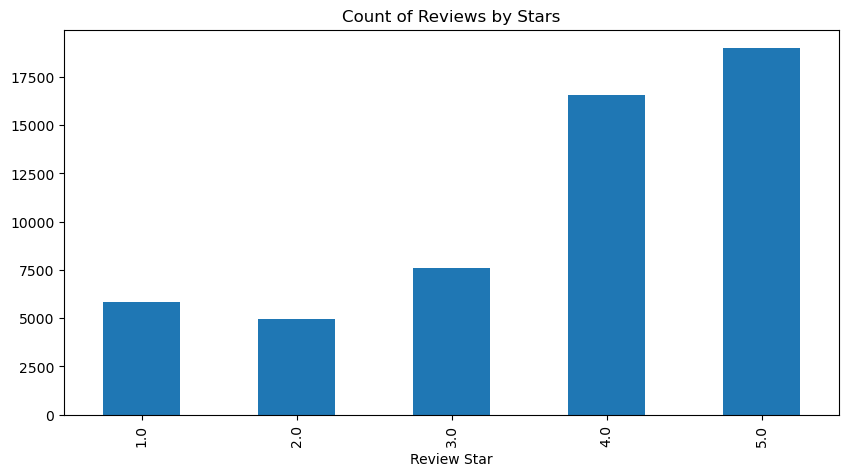

In [175]:
# Bar plot of positive and negative sentiment
ax = restaurants_df['stars_y'].value_counts().sort_index()\
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10,5))
ax.set_xlabel('Review Star')
plt.show()

### Build a supervised learning model for text analysis

F1 Score: 0.8448490803128039
Accuracy Score: 0.863265306122449


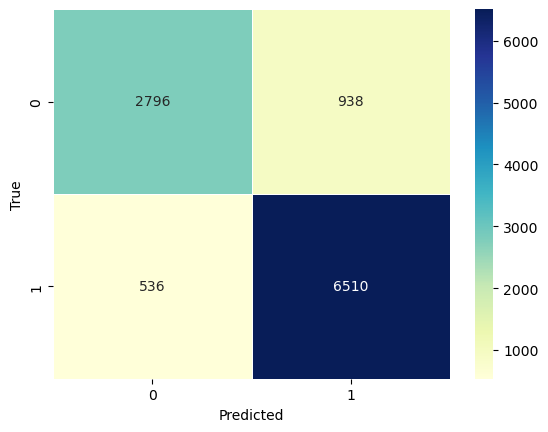

In [176]:
# Shuffle the data and split into train and test sets
x = restaurants_df['processed_text']
y = restaurants_df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Vectorize the text data
vectorizer = CountVectorizer()
x_train_vectors = vectorizer.fit_transform(x_train)
x_test_vectors = vectorizer.transform(x_test)

# Train Naive Bayes classifier
clf = MultinomialNB()
clf.fit(x_train_vectors, y_train)

# Predict the sentiment on the test set
y_pred = clf.predict(x_test_vectors)

# Evaluate the model
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


C:\Users\LENOVO\anaconda3\envs\envGEOG0051\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score: 0.8619743884889972
Accuracy Score: 0.8771799628942486


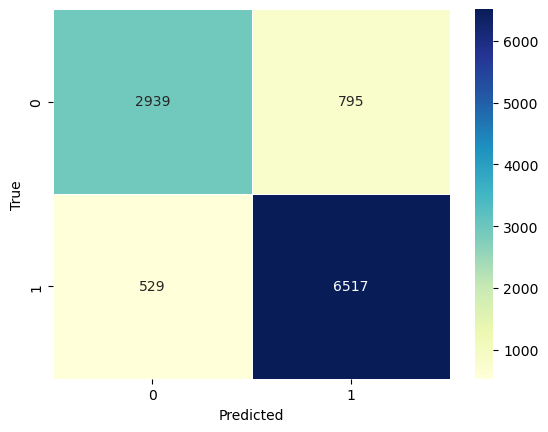

In [207]:
# Shuffle the data and split into train and test sets
x = restaurants_df['processed_text']
y = restaurants_df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Vectorize the text data
vectorizer = CountVectorizer()
x_train_vectors = vectorizer.fit_transform(x_train)
x_test_vectors = vectorizer.transform(x_test)

# Train Logistic Regression classifier
clf = LogisticRegression(solver='sag')
clf.fit(x_train_vectors, y_train)

# Predict the sentiment on the test set
y_pred = clf.predict(x_test_vectors)

# Evaluate the model
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


F1 Score: 0.8150591691137523
Accuracy Score: 0.8464749536178108


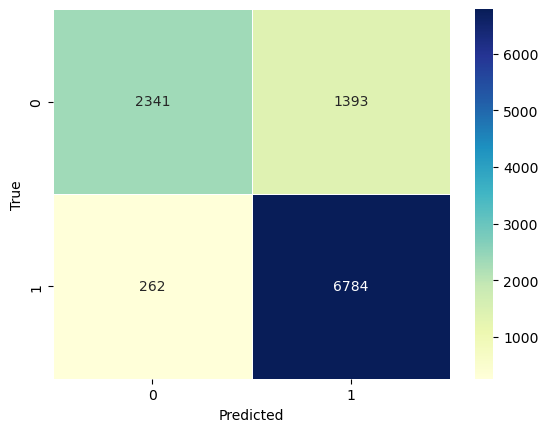

In [209]:
# Shuffle the data and split into train and test sets
x = restaurants_df['processed_text']
y = restaurants_df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# Vectorize the text data
vectorizer = CountVectorizer()
x_train_vectors = vectorizer.fit_transform(x_train)
x_test_vectors = vectorizer.transform(x_test)

# Train Random Forest classifier
clf = RandomForestClassifier()
clf.fit(x_train_vectors, y_train)

# Predict the sentiment on the test set
y_pred = clf.predict(x_test_vectors)

# Evaluate the model
print("F1 Score:", f1_score(y_test, y_pred, average='macro'))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


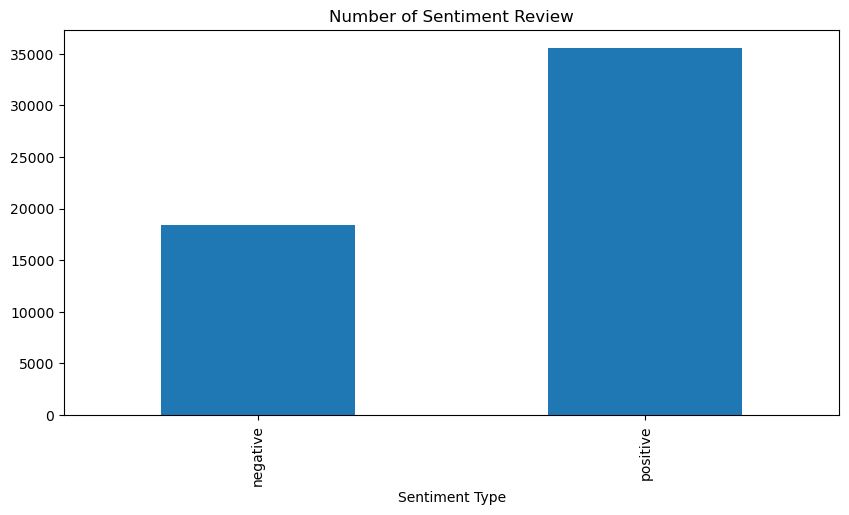

In [180]:
# Plot the number of sentiment reviews
ax = restaurants_df['sentiment'].value_counts().sort_index()\
    .plot(kind='bar',
          title='Number of Sentiment Review',
          figsize=(10,5))
ax.set_xlabel('Sentiment Type')
plt.show()


In [181]:
# Aggregate sentiment counts for each venue
venue_sentiment_counts = restaurants_df.groupby('name')['sentiment'].value_counts().unstack(fill_value=0)

# Merge with the original DataFrame to add latitude, longitude, and processed_categories columns
venue_sentiment_counts = pd.merge(venue_sentiment_counts, restaurants_df[['name', 'latitude', 'longitude', 'processed_categories']].drop_duplicates(), on='name', how='left')

# Determine overall sentiment for each venue
venue_sentiment_counts['overall_sentiment'] = venue_sentiment_counts['positive'] > venue_sentiment_counts['negative']
venue_sentiment_counts['overall_sentiment'] = venue_sentiment_counts['overall_sentiment'].map({True: 'positive', False: 'negative'})

# Generate final rating based on overall sentiment
venue_sentiment_counts['total_reviews'] = venue_sentiment_counts['positive'] + venue_sentiment_counts['negative']
venue_sentiment_counts['positive_percentage'] = venue_sentiment_counts['positive'] / venue_sentiment_counts['total_reviews']

# Define rating scale
rating_scale = {
    'positive': 'High Rating',  # Assign higher rating if more than 50% of reviews are positive
    'negative': 'Low Rating'    # Assign lower rating otherwise
}

# Map sentiment to final rating
venue_sentiment_counts['final_rating'] = venue_sentiment_counts['overall_sentiment'].map(rating_scale)

# Display the result
print(venue_sentiment_counts[['overall_sentiment', 'final_rating']])


     overall_sentiment final_rating
0             positive  High Rating
1             negative   Low Rating
2             negative   Low Rating
3             positive  High Rating
4             negative   Low Rating
...                ...          ...
1842          negative   Low Rating
1843          positive  High Rating
1844          negative   Low Rating
1845          positive  High Rating
1846          positive  High Rating

[1847 rows x 2 columns]


In [183]:
# Filter restaurants that contain 'halal' in their processed categories
restaurants_halal = venue_sentiment_counts[venue_sentiment_counts['processed_categories'].str.contains('halal')]

# Display the first few rows of the filtered DataFrame
restaurants_halal.head()

,name,negative,positive,latitude,longitude,processed_categories,overall_sentiment,total_reviews,positive_percentage,final_rating
57,Ali Baba Kabob House,7,23,51.038334,-114.094406,"afghan , restaurants , halal , mediterranean",positive,30,0.766667,High Rating
81,Aryana Cuisine,1,5,51.106867,-113.970102,"restaurants , afghan , halal , kebab , buffets...",positive,6,0.833333,High Rating
83,Asian Grill BBQ & Chinese,2,1,51.063992,-113.956759,"chinese , restaurants , pakistani , barbeque ,...",negative,3,0.333333,Low Rating
86,Atlas Specialty Supermarket & Persian Cuisine,12,19,51.045439,-114.084195,"persian/iranian , food , restaurants , middle ...",positive,31,0.612903,High Rating
97,Babylon Qithara,10,14,51.075445,-113.991273,"middle eastern , kebab , halal , restaurants",positive,24,0.583333,High Rating


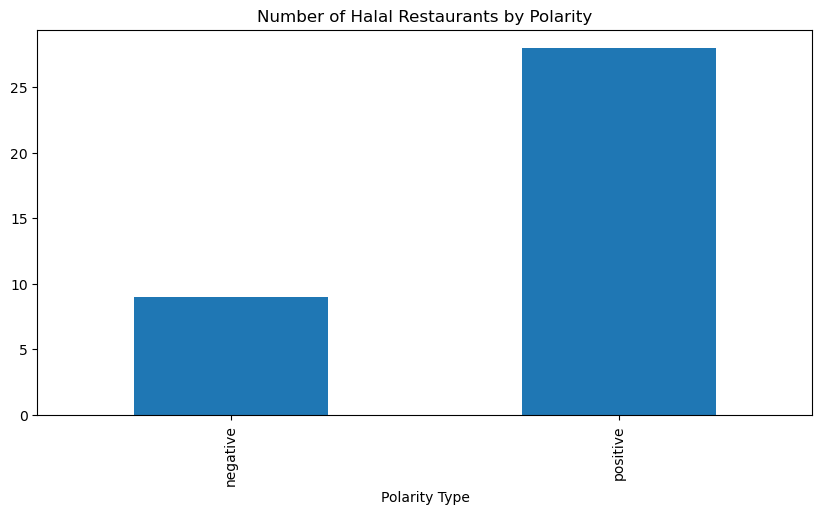

In [184]:
# Plot the number of Halal restaurants by polarity
ax = restaurants_halal['overall_sentiment'].value_counts().sort_index()\
    .plot(kind='bar',
          title='Number of Halal Restaurants by Polarity',
          figsize=(10,5))
ax.set_xlabel('Polarity Type')
plt.show()


In [185]:
# Subset data to find the location of positively reviewed Halal restaurants
positive_halal = restaurants_halal[restaurants_halal['overall_sentiment'] == 'positive']

# Create a GeoDataFrame with the 'latitude' and 'longitude' columns
gdf_positive_halal = gpd.GeoDataFrame(positive_halal, 
                                       geometry=gpd.points_from_xy(positive_halal['longitude'], positive_halal['latitude']),
                                       crs='EPSG:4326')

# Display the shape of the subset
positive_halal.shape


(28, 10)

In [186]:
# Subset data to find the location of negatively reviewed Halal restaurants
negative_halal = restaurants_halal[restaurants_halal['overall_sentiment'] == 'negative']

# Create a GeoDataFrame with the 'latitude' and 'longitude' columns
gdf_negative_halal = gpd.GeoDataFrame(negative_halal, 
                                      geometry=gpd.points_from_xy(negative_halal['longitude'], negative_halal['latitude']),
                                      crs='EPSG:4326')

# Display the shape of the subset
negative_halal.shape


(9, 10)

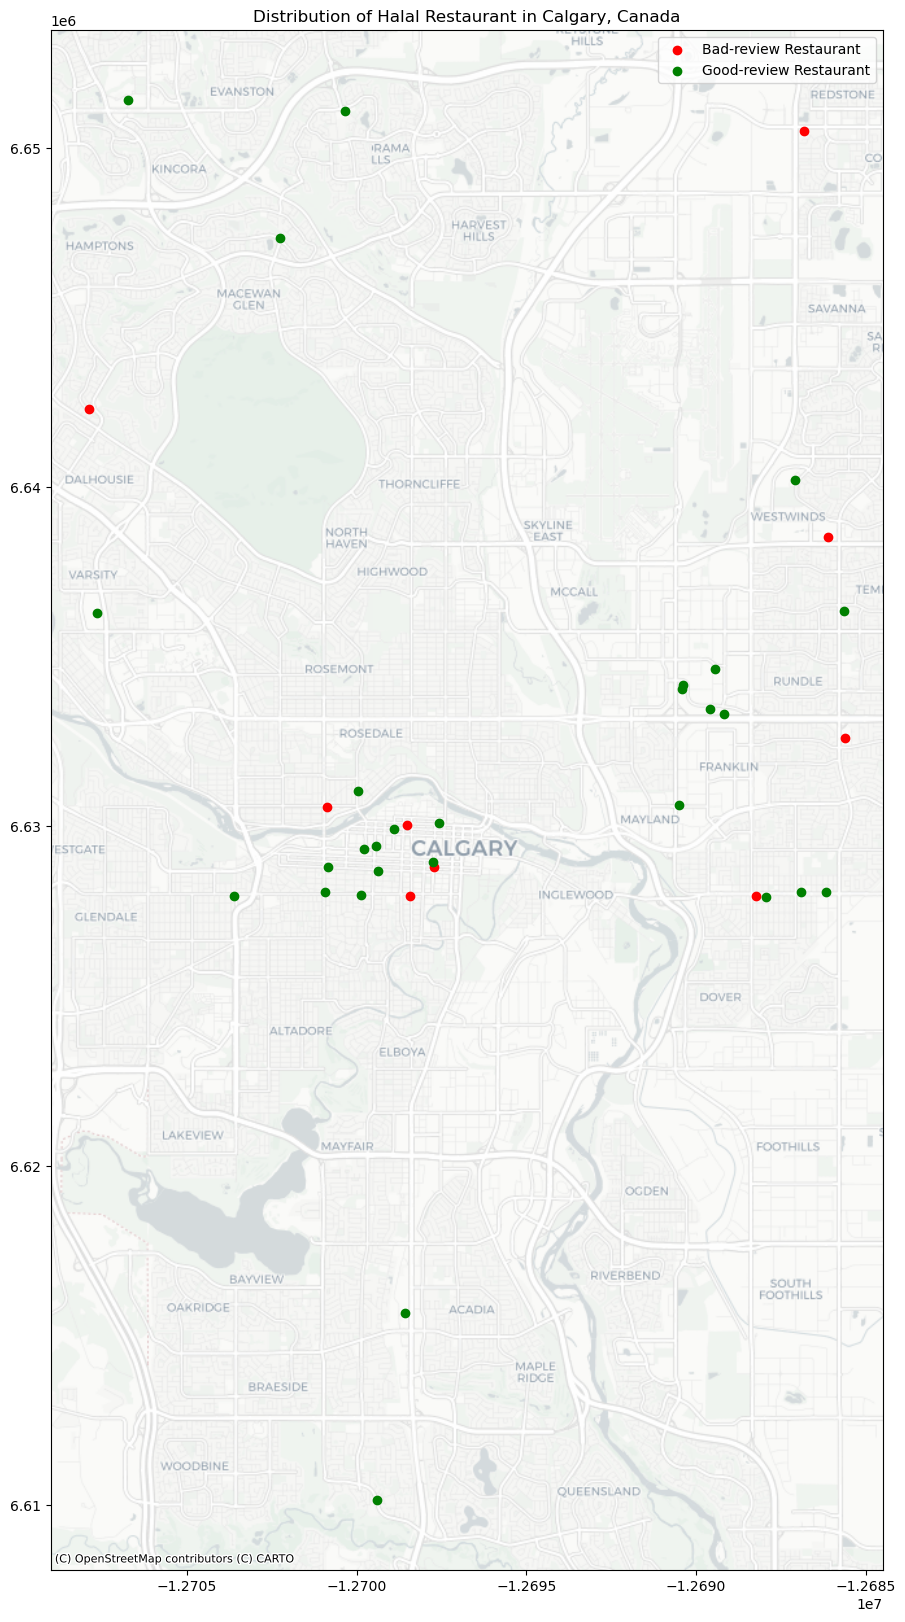

In [196]:
# Plot the GeoDataFrame with the basemap
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')  # Ensure aspect ratio is maintained

# Plot the GeoDataFrame gdf
gdf_negative_halal.plot(ax=ax, color='red', label ="Bad-review Restaurant")
gdf_positive_halal.plot(ax=ax, color='green', label = "Good-review Restaurant")

# Add basemap
cx.add_basemap(ax, crs=gdf_positive_halal.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Add legend
plt.legend()
plt.title('Distribution of Halal Restaurant in Calgary, Canada')

# Show plot
plt.show()


Based on the plot, the Downtown area has the highest concentration of Halal restaurants because of its significant population growth between 2016 and 2021, which favored the restaurant business.

### Network Analysis

In [153]:
# Retrieve the street network graph based on the address 'Downtown West End, Calgary, Canada'
G = ox.graph_from_address('Downtown West End, Calgary, Canada', dist=6000, network_type='drive')

In [ ]:
# Define tags to specify the types of features to retrieve
tags = {'amenity': True, 'highway': True, 'landuse': True, 'building': True, 'waterway': True, 'railway': True}
# Retrieve geometries of features near Downtown West End, Calgary, Canada, based on specified tags and within a specified distance
all_geom = ox.geometries.geometries_from_address('Downtown West End, Calgary, Canada', tags, dist=6000)
# Convert geometries to Web Mercator projection (EPSG:3857) for compatibility with most web maps
all_geom = all_geom.to_crs(epsg=3857)

In [156]:
# Create a directed graph representation from the retrieved graph
DG = ox.get_digraph(G)

# Calculate closeness centrality for edges in the drive network graph by converting it to a line graph
edge_cc = nx.closeness_centrality(nx.line_graph(DG))

# Calculate betweenness centrality for edges in the drive network graph by converting it to a line graph
edge_bc = nx.betweenness_centrality(nx.line_graph(DG))

# Assign closeness centrality values ('cc') as edge attributes to the drive network graph (DG)
nx.set_edge_attributes(DG, edge_cc,'cc')

# Assign betweenness centrality ('bc') as edge attributes to the drive network graph (DG)
nx.set_edge_attributes(DG, edge_bc,'bc')

# Create a multigraph (WG1) from the directed graph (DG)
WG1 = nx.MultiGraph(DG)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19752\616437501.py:12: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  all_geom[all_geom['building'] == 'mosque'].plot(ax=ax, color='black')


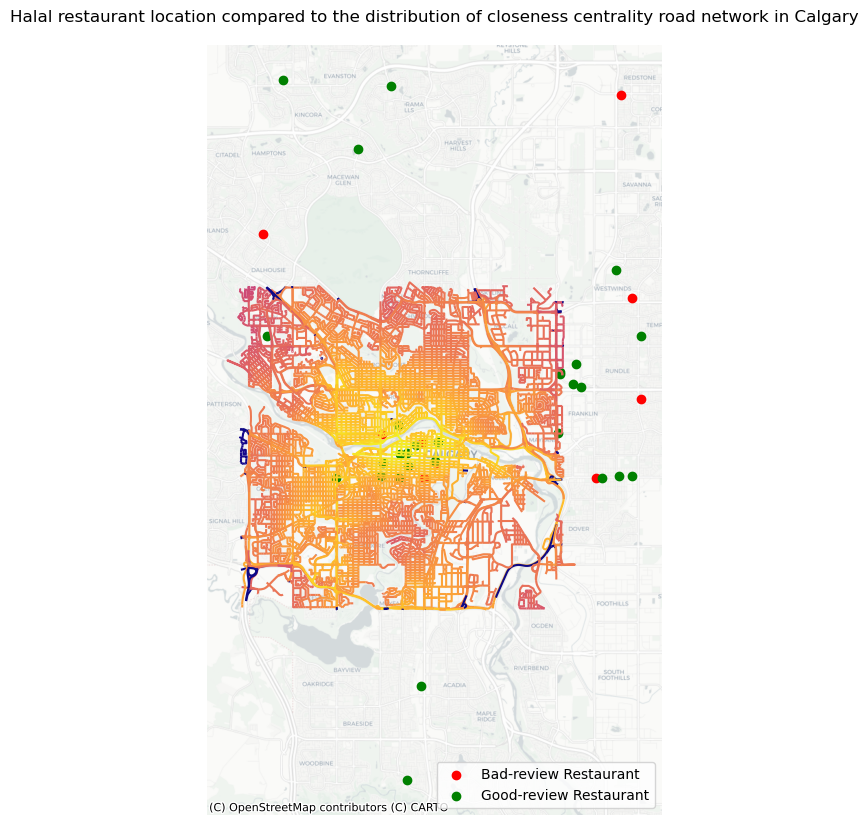

In [204]:
# Visualize the closeness centrality by adding a basemap
# Convert the graph to a GeoPandas dataframe
gdf_edges = ox.graph_to_gdfs(WG1, nodes=False, fill_edge_geometry=True)

# Set the coordinate reference system (CRS) to EPSG:3857 (needed for contextily)
gdf_edges = gdf_edges.to_crs(epsg=3857)

# Plot edges according to closeness centrality
ax = gdf_edges.plot('cc', cmap='plasma', figsize=(10, 10))

# Symbolize all retail buildings (mosques in this case) on the plot in black color
all_geom[all_geom['building'] == 'mosque'].plot(ax=ax, color='black')

# Plot the locations of halal restaurants with bad reviews in red
gdf_negative_halal.plot(ax=ax, color='red', label ="Bad-review Restaurant")

# Plot the locations of halal restaurants with good reviews in green
gdf_positive_halal.plot(ax=ax, color='green', label = "Good-review Restaurant")

# Add a basemap using contextily
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Turn off axis
plt.axis('off')

# Set plot title
plt.title('Halal restaurant location compared to the distribution of closeness centrality road network in Calgary')

# Add legend
plt.legend()

# Display the plot
plt.show()


Halal restaurants tend to be located on medium to high closeness centrality roads around the Downtown area, due to their accessibility and potential profitability

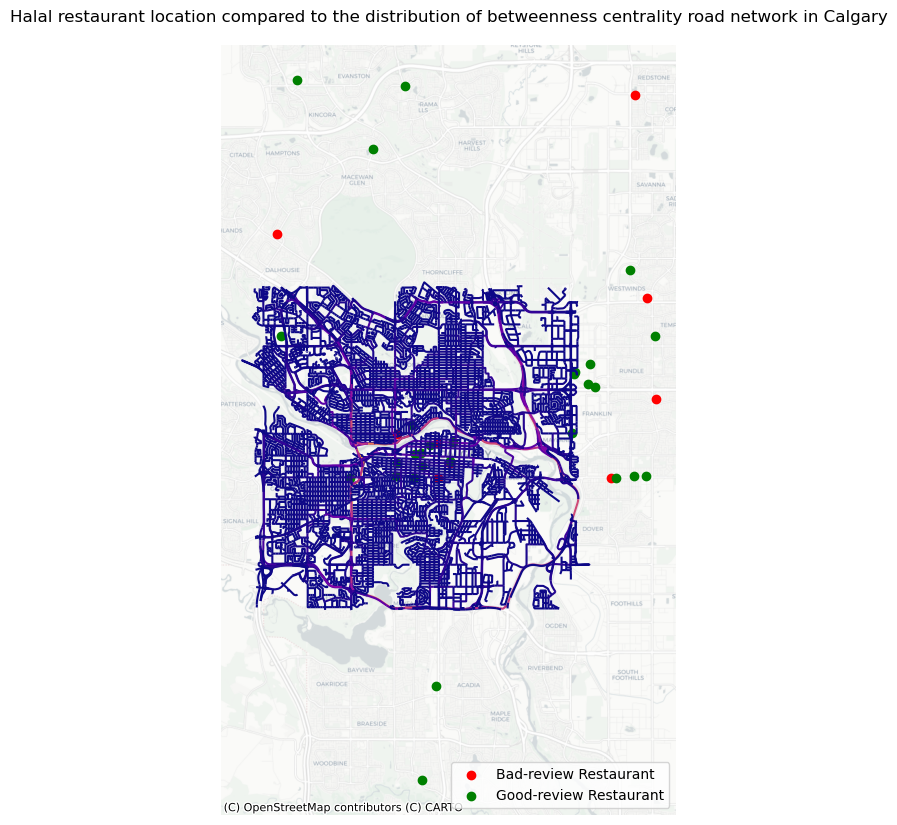

In [205]:
# Visualize the betweenness centrality by adding a basemap
# Convert the graph to a GeoPandas dataframe
gdf_edges = ox.graph_to_gdfs(WG1, nodes=False, fill_edge_geometry=True)

# Set the coordinate reference system (CRS) to EPSG:3857 (needed for contextily)
gdf_edges = gdf_edges.to_crs(epsg=3857)

# Plot edges according to betweenness centrality
ax = gdf_edges.plot('bc', cmap='plasma', figsize=(10, 10))

# Symbolize all retail buildings (halal restaurants in this case) with bad reviews in red
gdf_negative_halal.plot(ax=ax, color='red', label ="Bad-review Restaurant")

# Symbolize all retail buildings (halal restaurants in this case) with good reviews in green
gdf_positive_halal.plot(ax=ax, color='green', label = "Good-review Restaurant")

# Add a basemap using contextily
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Set plot title
plt.title('Halal restaurant location compared to the distribution of betweenness centrality road network in Calgary')

# Add legend
plt.legend()

# Turn off axis
plt.axis('off')

# Display the plot
plt.show()


Interestingly, most restaurants in Calgary are located on roads with low betweenness centrality. This might be due to the restaurants' desire to avoid traffic congestion and minimize pollution from high-traffic roads, which can be off-putting to customers.

### Potential areas for new halal restaurant

Based on the previous analysis, it is suggested that a potential location for a new halal restaurant is around (6629339.013273707 -12699830.896434017) EPSG:3857. This location has a high potential for customers due to its large population compared to other areas. Additionally, the area is surrounded by high-rating (positive polarity) halal restaurants which can increase the visibility of a new restaurant, as people tend to go to well-reviewed restaurants. Furthermore, this location is located in an area with high closeness centrality but low traffic volume, meaning that it has good accessibility and a low potential for traffic jams.

Reference
-------------------------------

(1) The City of Calgary. Data about Calgary's population. [online]. ODI: Calgary; 2024 [Accessed 23 April 2024]. Available from: https://www.calgary.ca/research/population-profile.html